[View in Colaboratory](https://colab.research.google.com/github/Hoiy/kaggle-santander-value-prediction-challenge/blob/master/model_lightgbm.ipynb)

In [1]:
import pandas as pd
import numpy as np
import dotenv
import os
from scipy import sparse
import pickle
import gc
import lightgbm as lgb

dotenv.load_dotenv('.env')

/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


True

In [0]:
!mkdir prep
!gsutil rsync gs://{os.environ['GCP_BUCKET']}/prep prep

mkdir: prep: File exists
Building synchronization state...
Starting synchronization...
Copying gs://kaggle-195720-santander-value-prediction-challenge/prep/test.csv...
^C


In [2]:
X = pd.concat([
    pd.read_parquet('./prep/train_log_feats.snappy.parquet'), 
    pd.read_parquet('./prep/train_log_stats.snappy.parquet'),
  ],
  axis=1
)
y = pd.read_parquet('./prep/train_log_target.snappy.parquet')['target']
leak = pd.read_parquet('./prep/train_leak.snappy.parquet')['pred']
X.shape, y.shape

((4459, 5003), (4459,))

In [0]:
X_test = pd.concat([
    pd.read_parquet('./prep/test_log_feats.snappy.parquet'), 
    pd.read_parquet('./prep/test_log_stats.snappy.parquet'),
  ],
  axis=1
)

In [0]:
X_no_leak = X[leak == 0]
y_no_leak = y[leak == 0]

In [0]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
RANDOM_SEED=42

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [0]:
#TODO: how to setup gpu lightgbm in colab
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'metric': {'rmse'},
#     'min_data_in_leaf': 1000,
#     'num_leaves': 250,
#     'feature_fraction': 0.8,
#     'bagging_freq': 10,
#     'bagging_fraction': 0.5,
#     'max_depth': 8,
#     'min_data_in_leaf': 1000,
#     'device': 'gpu',
#     'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.0175,
    'verbose': 1
}

lgb_params = {
    'verbose_eval': 10,
}

In [22]:
K_FOLD=int(1/TEST_SIZE)

lgb_cv = lgb.Dataset(X_cv, y_cv, feature_name=X.columns.tolist())
results = lgb.cv(
    params,
    lgb_cv,
    stratified=False,
    nfold=K_FOLD,
    seed=42,
    num_boost_round=10000,
    early_stopping_rounds=10,
    **lgb_params
)

[10]	cv_agg's rmse: 1.65656 + 0.0860822
[20]	cv_agg's rmse: 1.5749 + 0.0972814
[30]	cv_agg's rmse: 1.5138 + 0.107907
[40]	cv_agg's rmse: 1.46898 + 0.118518
[50]	cv_agg's rmse: 1.43573 + 0.125276
[60]	cv_agg's rmse: 1.41422 + 0.130941
[70]	cv_agg's rmse: 1.396 + 0.136373
[80]	cv_agg's rmse: 1.38401 + 0.14045
[90]	cv_agg's rmse: 1.37694 + 0.142857
[100]	cv_agg's rmse: 1.37133 + 0.143414
[110]	cv_agg's rmse: 1.36919 + 0.144359
[120]	cv_agg's rmse: 1.36654 + 0.14557
[130]	cv_agg's rmse: 1.36433 + 0.146453
[140]	cv_agg's rmse: 1.36423 + 0.147234


In [23]:
cv = results['rmse-mean'][-1]
rounds = len(results['rmse-mean'])
rounds, cv, K_FOLD, 1/K_FOLD

(134, 1.3638595834824785, 10, 0.1)

In [0]:
def fit_predict(data, y, test):
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    # Get the features we're going to train on 
    features = data.columns.tolist()
    # Create folds
    folds = KFold(n_splits=10, shuffle=True, random_state=1)
    # Convert to lightgbm Dataset
    dtrain = lgb.Dataset(data=data[features], label=y, free_raw_data=False)
    # Construct dataset so that we can use slice()
    dtrain.construct()
    # Init predictions
    sub_preds = np.zeros(test.shape[0])
    oof_preds = np.zeros(data.shape[0])
    # Lightgbm parameters
    # Optimized version scores 0.40
    # Step |   Time |      Score |      Stdev |   p1_leaf |   p2_subsamp |   p3_colsamp |   p4_gain |   p5_alph |   p6_lamb |   p7_weight |
    #   41 | 00m04s |   -1.36098 |    0.02917 |    9.2508 |       0.7554 |       0.7995 |   -3.3108 |   -0.1635 |   -0.9460 |      0.6485 |
    lgb_params = {
        'objective': 'regression',
        'num_leaves': 58,
        'subsample': 0.6143,
        'colsample_bytree': 0.6453,
        'min_split_gain': np.power(10, -2.5988),
        'reg_alpha': np.power(10, -2.2887),
        'reg_lambda': np.power(10, 1.7570),
        'min_child_weight': np.power(10, -0.1477),
        'verbose': -1,
        'seed': 3,
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.01,
        'metric': 'rmse',
    }
    # Run KFold
    for trn_idx, val_idx in folds.split(data):
        # Train lightgbm
        clf = lgb.train(
            params=lgb_params,
            train_set=dtrain.subset(trn_idx),
            valid_sets=dtrain.subset(val_idx),
            num_boost_round=10000, 
            early_stopping_rounds=100,
            verbose_eval=50
        )
        # Predict Out Of Fold and Test targets
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
        sub_preds += clf.predict(test[features]) / folds.n_splits
        # Display current fold score
        print(mean_squared_error(y.iloc[val_idx], 
                                 oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    print('Full Out-Of-Fold score : %9.6f' 
          % (mean_squared_error(y, oof_preds) ** .5))

    return oof_preds, sub_preds

In [18]:
oof_preds, sub_preds = fit_predict(X_no_leak, y_no_leak, X_test)
X_test['pred'] = sub_preds
X_test[['pred']].to_parquet('./prep/lightgbm.snappy.paruqet')

!gsutil cp ./prep/lightgbm.snappy.paruqet gs://{os.environ['GCP_BUCKET']}/prep/lightgbm.snappy.paruqet

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.37412
[100]	valid_0's rmse: 1.27393
[150]	valid_0's rmse: 1.22314
[200]	valid_0's rmse: 1.19652
[250]	valid_0's rmse: 1.1831
[300]	valid_0's rmse: 1.17954
[350]	valid_0's rmse: 1.17887
[400]	valid_0's rmse: 1.17756
[450]	valid_0's rmse: 1.17556
[500]	valid_0's rmse: 1.17439
[550]	valid_0's rmse: 1.17263
[600]	valid_0's rmse: 1.17157
[650]	valid_0's rmse: 1.17043
[700]	valid_0's rmse: 1.17233
[750]	valid_0's rmse: 1.17374
Early stopping, best iteration is:
[650]	valid_0's rmse: 1.17043
1.1704259830150814
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's rmse: 1.56752
[100]	valid_0's rmse: 1.46893
[150]	valid_0's rmse: 1.4154
[200]	valid_0's rmse: 1.38797
[250]	valid_0's rmse: 1.37556
[300]	valid_0's rmse: 1.3702
[350]	valid_0's rmse: 1.36658
[400]	valid_0's rmse: 1.36545
[450]	valid_0's rmse: 1.3636
[500]	valid_0's rmse: 1.36865
Early stopping, best iteration is:
[441]	valid

In [25]:
# from sklearn.preprocessing import KFold

# folds = KFold(n_splits=10, shuffle=True, random_state=1)
#     # Convert to lightgbm Dataset
# #     dtrain = lgb.Dataset(data=data[features], label=np.log1p(y['target']), free_raw_data=False)
# dtrain = lgb.Dataset(X, y, feature_name=X.columns.tolist(), free_raw_data=False)

# dtrain.construct()
# # Init predictions
# sub_preds = np.zeros(test.shape[0])
# oof_preds = np.zeros(data.shape[0])

# for trn_idx, val_idx in folds.split(X):
  
    
    
# X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
# X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=1/K_FOLD, random_state=RANDOM_SEED)

# lgb_train = lgb.Dataset(X_train, y_train, feature_name=X.columns.tolist())
# lgb_val = lgb.Dataset(X_val, y_val, feature_name=X.columns.tolist(), reference=lgb_train)

# lgb_test = lgb.Dataset(X_test, y_test, feature_name=X.columns.tolist())

# model = lgb.train(
#     params,
#     lgb_train,
#     valid_names=['val'],
#     valid_sets=[lgb_val],
#     num_boost_round=10000,
#     early_stopping_rounds=10,
#     **lgb_params
# )

# X_train.shape, X_val.shape, X_test.shape, 

Training until validation scores don't improve for 10 rounds.
[10]	val's rmse: 1.7186
[20]	val's rmse: 1.64682
[30]	val's rmse: 1.59528
[40]	val's rmse: 1.55306
[50]	val's rmse: 1.52762
[60]	val's rmse: 1.51413
[70]	val's rmse: 1.50376
[80]	val's rmse: 1.49306
[90]	val's rmse: 1.48886
[100]	val's rmse: 1.48399
[110]	val's rmse: 1.48084
Early stopping, best iteration is:
[109]	val's rmse: 1.47869


((810, 5003), (90, 5003), (100, 5003))

In [19]:
from sklearn.metrics import mean_squared_error

X.loc[leak == 0, 'pred'] = oof_preds
X.loc[leak != 0, 'pred'] = np.log1p(leak[leak!=0])
mean_squared_error(X['pred'], y)

0.4507797107488712

ID
000d6aaf2    17.453097
000fbd867    13.304687
002dbeb22    14.845130
003925ac6    12.007628
003eb0261    13.304687
004b92275    13.794288
0067b4fef    13.038984
00689ee2c    13.910822
0069007ac    16.588099
006b60dd7    12.777055
008057126    15.761421
0096e207e    13.592368
00c2deb75    12.206078
00ce2134f    15.096445
00e7ba121    14.840118
00ecc53f2    10.596660
00fb69afe    14.285515
00fc78888    14.999281
0110c05db    15.630335
0126abf21    16.515932
012d8bc84    12.899222
012d9baab    15.687313
01346ebb9    14.346139
013842698    13.746519
01432f2c7    15.201805
0161ebeea    15.355956
01666d7a4    13.698978
017ad263f    15.607270
01b1dd07c    14.508658
01b4c938b    15.671809
               ...    
fd69c65d3    14.994166
fd801ee9d    16.231424
fd992de8a    13.907179
fdac3144d    15.640060
fdc71f3af    15.103917
fdec1a81a    13.122365
fdf7658f0    13.880050
fe0c5726a    16.811243
fe22d064a    16.811243
fe243db29    14.603968
fe497b462    11.211834
fe5414c97    13.592368
fe596c7c

In [0]:
# from sklearn.metrics import mean_squared_error

# pred = model.predict(X)
# np.sqrt(mean_squared_error(y, pred))

In [0]:
# PSEUDO_DATA_CUTOFF = 8

# target_hist = train.groupby('target').size()
# thresholds = target_hist[target_hist >= PSEUDO_DATA_CUTOFF].index

# def find_nearest(pred, thresholds):
#   if pred < thresholds[0]:
#     return thresholds[0]

#   # pred >= thresholds[0]
#   prev_diff = pred - thresholds[0]
#   for i in range(len(thresholds)-1):
#     if pred >= thresholds[i] and pred < thresholds[i+1]:
#       if prev_diff <= thresholds[i+1] - pred:
#         return thresholds[i]
#       else:
#         return thresholds[i+1]
  
#   return thresholds[-1]

# fixed_pred = []
# for p in pred:
#   fixed_pred.append(find_nearest(p, thresholds))
  
# np.sqrt(mean_squared_error(y, fixed_pred))

In [0]:
model

Text(0.5,1,'Light GBM Feature Importance')

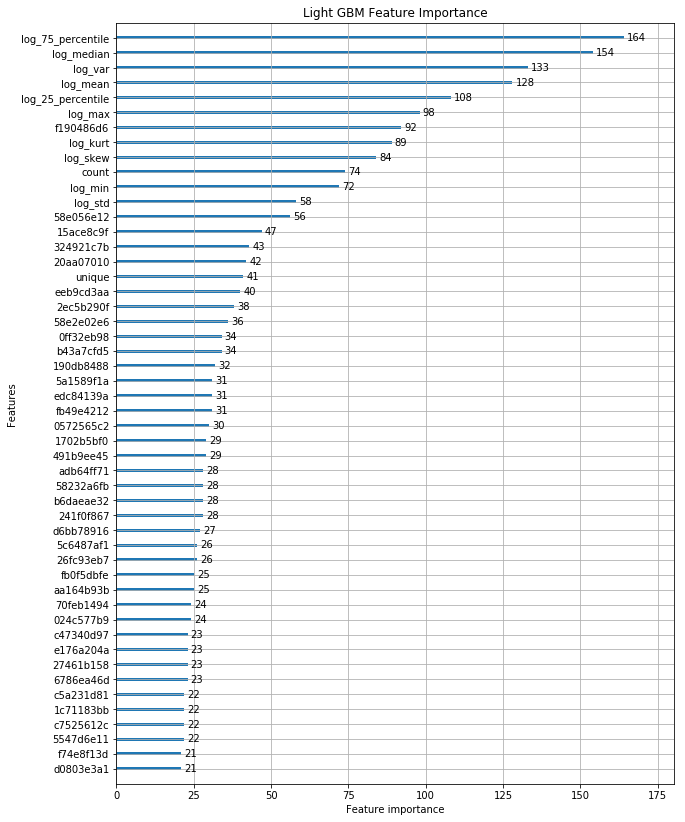

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [0]:
model.best_score

defaultdict(dict,
            {'test': {'rmse': 1.3710512192485305},
             'train': {'rmse': 1.0179767538179547},
             'val': {'rmse': 1.3297995362963604}})

In [0]:
!mkdir ./model
model.save_model('./model/lightgbm.dat')
!gsutil rsync model gs://{os.environ['GCP_BUCKET']}/model

mkdir: ./model: File exists
Building synchronization state...
Starting synchronization...
Copying file://model/lightgbm.dat [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/662.7 KiB.                                    


In [0]:
# !mkdir model
# !gsutil rsync gs://{os.environ['GCP_BUCKET']}/model model
  
# model = lgb.Booster(model_file='./model/lightgbm.dat')

In [0]:
X_test = pd.concat([pd.read_parquet('./prep/test_log_feats.snappy.parquet'), pd.read_parquet('./prep/test_log_stats.snappy.parquet')], axis=1)

In [0]:
SUBMISSION_FILE = 'lightgbm.csv'
SUBMISSION_MESSAGE='"LightGBM test_size %.4f, k_fold %d, train %.4f val %.4f test %.4f cv %.4f"'%(TEST_SIZE, K_FOLD, model.best_score['train']['rmse'], model.best_score['val']['rmse'], model.best_score['test']['rmse'], cv)
# SUBMISSION_MESSAGE='"LightGBM train %.4f test %.4f"'%(1.059, 1.306)

test = pd.DataFrame({
    'ID': X_test.index,
    'target': np.exp1m(model.predict(X_test))
})
test[['ID', 'target']].to_csv(SUBMISSION_FILE, index=False)
print(SUBMISSION_MESSAGE)

"LightGBM test_size 0.1000, k_fold 10, train 1.0314 val 1.3423 test 1.3683 cv 1.3394"


In [0]:
# test.loc[test.ID.isin(X_test[X_test['count'] == X_test['unique']]).index, ['target']] = 0
test.loc[test.ID.isin((X_test[X_test['count'] == X_test['unique']]).index), ['target']] = 0
test.to_csv(SUBMISSION_FILE, index=False)

In [0]:
!head ./lightgbm.csv

ID,target
000137c73,0.0
00021489f,0.0
0004d7953,1551408.2641500651
00056a333,3734011.8777573723
00056d8eb,0.0
0005fc190,0.0
000787e86,0.0
0008510a0,0.0
000895faf,0.0


In [0]:
!kaggle competitions submit -f '{SUBMISSION_FILE}' -m '{SUBMISSION_MESSAGE}'

Using competition: santander-value-prediction-challenge
Successfully submitted to Santander Value Prediction Challenge